In [ ]:
%matplotlib inline

## Requirements

In [228]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [229]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [230]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [231]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [232]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [233]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    data = []
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        data.append(pair[1])
    random.shuffle(data)
    train_set = data[:10000]
    test_set = data[10000:]
    
    f1 = open('train.txt', 'w')
    for i in range(len(train_set)):
        f1.write(train_set[i] + '\n')
    f1.close()
    
    f2 = open('test.txt', 'w')
    for i in range(len(test_set)):
        f2.write(test_set[i] + '\n')
    f2.close()

    
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



input_lang, output_lang, _ = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
[Variable containing:
 1059
  345
 7241
 2560
    2
    0
    0
    0
[torch.LongTensor of size 8]
, Variable containing:
    2
    3
  613
  539
 1269
    4
    1
[torch.LongTensor of size 7x1]
]


In [234]:
import spacy
import numpy as np

import argparse
import pickle as pkl

from collections import OrderedDict

In [235]:
nlp = spacy.load('en')

def extract_ngrams(vocab, sent, order=3):
    # tokenization
    uwords = [t.text for t in nlp(str(sent))]
    for ng in set([' '.join(t).strip() for t in zip(*[uwords[i:] for i in range(order)])]):
        if ng in vocab:
            vocab[ng] += 1
        else:
            vocab[ng] = 1

    return vocab

In [236]:
def createDictionary(source, saveto, order=3):

    vocab0 = OrderedDict()

    with open(source, 'r') as f:
        #cols = [c.strip() for c in header.split('\t')]
        
        for li, line in enumerate(f):
            #cols = [c.strip() for c in line.split('\t')]
            vocab0 = extract_ngrams(vocab0, line.lower(), order=order)

            if np.mod(li, 1000) == 0:
                print('Processed {} lines so far..'.format(li+1))

    tokens = list(vocab0.keys())
    freqs = list(vocab0.values())
    sidx = np.argsort(freqs)[::-1]
    vocab = OrderedDict([(tokens[s],i+1) for i, s in enumerate(sidx)])

    with open(saveto, 'wb') as f:
        #pkl.dump(vocab, f, protocol=pkl.HIGHEST_PROTOCOL)
        pkl.dump(vocab, f, protocol=pkl.HIGHEST_PROTOCOL) # frequency

    with open('dictionary.pickle', 'rb') as handle:
        b = pkl.load(handle)
    
    for key, value in vocab.items():
        print(key, value)
    assert(vocab == b)

In [237]:
createDictionary('eng.txt', 'dictionary.pickle',2)

Processed 1 lines so far..
Processed 1001 lines so far..
Processed 2001 lines so far..
Processed 3001 lines so far..
Processed 4001 lines so far..
Processed 5001 lines so far..
Processed 6001 lines so far..
Processed 7001 lines so far..
Processed 8001 lines so far..
Processed 9001 lines so far..
Processed 10001 lines so far..
. 1
i m 2
you re 3
we re 4
he is 5
m not 6
he s 7
i am 8
re not 9
you . 10
they re 11
she is 12
re very 13
you are 14
going to 15
she s 16
is a 17
me . 18
re all 19
s a 20
here . 21
m going 22
re the 23
they are 24
m sorry 25
? 26
aren t 27
we are 28
now . 29
m a 30
m glad 31
you ? 32
it . 33
not a 34
re going 35
re a 36
him . 37
to be 38
happy . 39
that . 40
t you 41
m very 42
! 43
in the 44
not going 45
out of 46
friend . 47
this . 48
tom . 49
re too 50
afraid of 51
teacher . 52
a good 53
to see 54
proud of 55
busy . 56
s not 57
for you 58
glad to 59
re in 60
to go 61
tired . 62
alone . 63
re so 64
m just 65
m sure 66
glad you 67
good at 68
is not 69
the one 70


blinded by 1085
duty . 1086
re happy 1087
s just 1088
re smarter 1089
tidy . 1090
re winning 1091
ugly . 1092
re forgiven 1093
forgiven . 1094
to lose 1095
charming . 1096
through . 1097
insane . 1098
before . 1099
with that 1100
you to 1101
better than 1102
by love 1103
type . 1104
dancing . 1105
prisoners . 1106
bright . 1107
re powerful 1108
to smoke 1109
him with 1110
re depressed 1111
very skeptical 1112
re ambitious 1113
on you 1114
pretty . 1115
opinion . 1116
winning . 1117
of mine 1118
seems to 1119
s kind 1120
incredibly talented 1121
teachers . 1122
next week 1123
years younger 1124
class . 1125
very lonely 1126
on my 1127
here for 1128
s here 1129
month . 1130
m out 1131
swimming . 1132
next month 1133
m free 1134
of being 1135
go there 1136
expecting a 1137
lawyer . 1138
very angry 1139
to drink 1140
m working 1141
of making 1142
re conscientious 1143
my type 1144
very big 1145
in that 1146
gorgeous . 1147
re taking 1148
re surrounded 1149
surrounded . 1150
longer welcome 

re opportunistic 1943
a millionaire 1944
beautiful than 1945
still waiting 1946
do . 1947
s never 1948
a scientist 1949
re nice 1950
take a 1951
in part 1952
every day 1953
really happy 1954
frightened of 1955
you any 1956
part responsible 1957
been happy 1958
need some 1959
re similar 1960
very well 1961
regret this 1962
not particularly 1963
to regret 1964
pictures . 1965
not sick 1966
s innocent 1967
as beautiful 1968
am married 1969
of an 1970
like this 1971
very serious 1972
so cute 1973
but i 1974
always right 1975
after me 1976
phone . 1977
more money 1978
volunteering . 1979
staying here 1980
s already 1981
s after 1982
really angry 1983
bigot . 1984
a bigot 1985
in pain 1986
re different 1987
re nearly 1988
your brother 1989
to ask 1990
beautiful as 1991
home on 1992
am at 1993
are free 1994
re under 1995
to fix 1996
retired too 1997
for money 1998
not partners 1999
tight . 2000
is watching 2001
poet . 2002
surprised him 2003
having trouble 2004
are watching 2005
getting invol

blame . 2834
concentrating . 2835
re starting 2836
attention . 2837
in all 2838
are running 2839
re one 2840
a muslim 2841
re assertive 2842
an office 2843
is pleased 2844
muslim . 2845
hands . 2846
authority on 2847
s older 2848
quite a 2849
by profession 2850
is now 2851
to trust 2852
profession . 2853
accident . 2854
nothing . 2855
of heights 2856
heights . 2857
re first 2858
to us 2859
the city 2860
re fussy 2861
two . 2862
terrible dancer 2863
neatly dressed 2864
re wanted 2865
always neatly 2866
paying attention 2867
re sad 2868
will make 2869
really tight 2870
very ill 2871
of me 2872
studying . 2873
weird . 2874
edges . 2875
rough around 2876
the edges 2877
a tennis 2878
working at 2879
s stronger 2880
all to 2881
am dying 2882
grateful for 2883
o clock 2884
studying now 2885
a mistake 2886
as he 2887
grave danger 2888
to sing 2889
re exhausted 2890
cute isn 2891
to join 2892
legs . 2893
in our 2894
head of 2895
the head 2896
three children 2897
case . 2898
hot . 2899
a freelan

m fully 3833
right for 3834
for dinner 3835
new ideas 3836
my dream 3837
coast . 3838
the sofa 3839
honest at 3840
sofa . 3841
that i 3842
am short 3843
am undressing 3844
not honest 3845
ordering you 3846
teacher s 3847
old friend 3848
only joking 3849
to catch 3850
re clean 3851
s english 3852
make amends 3853
amends . 3854
is unsatisfied 3855
unsatisfied with 3856
all bored 3857
clean . 3858
re halfway 3859
i like 3860
college students 3861
all college 3862
just nervous 3863
all armed 3864
all angry 3865
not involved 3866
to sell 3867
sell it 3868
re canadians 3869
canadians . 3870
gambling anymore 3871
done talking 3872
both fine 3873
did . 3874
talking on 3875
new . 3876
something new 3877
drunk to 3878
help her 3879
busy to 3880
busy on 3881
best friends 3882
re awake 3883
dedicated . 3884
re dedicated 3885
re committed 3886
re contented 3887
out now 3888
re close 3889
s married 3890
committed . 3891
to like 3892
up a 3893
to trouble 3894
trouble you 3895
not gambling 3896
sure y

danger tom 4833
good with 4834
a lesson 4835
laugh . 4836
to laugh 4837
re grown 4838
rested . 4839
just as 4840
always singing 4841
as confused 4842
confused as 4843
seriously ill 4844
are seriously 4845
a mean 4846
not bleeding 4847
the american 4848
m rested 4849
really sure 4850
nearly finished 4851
nowhere . 4852
getting nowhere 4853
grown up 4854
being fair 4855
popular songs 4856
safe there 4857
whole picture 4858
re asleep 4859
advantage of 4860
york next 4861
are bored 4862
are alone 4863
early for 4864
weakness . 4865
her weakness 4866
leg . 4867
pulling my 4868
my leg 4869
taking advantage 4870
m ruined 4871
cantankerous . 4872
over analyzing 4873
analyzing . 4874
re over 4875
of excuses 4876
lesson . 4877
that crazy 4878
hottie . 4879
town for 4880
leaving town 4881
completely lost 4882
immune . 4883
m immune 4884
wasting ammo 4885
screamed for 4886
nurse . 4887
m wide 4888
obviously very 4889
m obviously 4890
no fun 4891
good speaker 4892
re single 4893
smoking . 4894
m un

easygoing . 5582
not outgoing 5583
touched me 5584
who touched 5585
not offended 5586
pleased . 5587
re upset 5588
little busy 5589
independent thinker 5590
an independent 5591
thinker . 5592
you waiting 5593
a most 5594
his reasons 5595
tom had 5596
t go 5597
reasons . 5598
in oriental 5599
this hot 5600
hot weather 5601
baking bread 5602
broke my 5603
oriental pottery 5604
pottery . 5605
with french 5606
am baking 5607
i broke 5608
my promise 5609
promise . 5610
am proud 5611
disgusted . 5612
worst . 5613
why . 5614
the worst 5615
by you 5616
still intimidated 5617
most beautiful 5618
kept you 5619
have kept 5620
bragging . 5621
m extremely 5622
just curious 5623
feeling dizzy 5624
flabbergasted . 5625
m flabbergasted 5626
busy learning 5627
learning english 5628
an authority 5629
her children 5630
promising young 5631
a promising 5632
her daughter 5633
housesitting . 5634
homeschooled . 5635
m homeschooled 5636
winning aren 5637
wealthy aren 5638
investigation . 5639
under investiga

is pigeon 6582
a writer 6583
s annoying 6584
stronger now 6585
re hot 6586
m stronger 6587
beyond hope 6588
m unenthusiastic 6589
re newlyweds 6590
beyond help 6591
detective . 6592
dramatist . 6593
london . 6594
a dramatist 6595
m first 6596
is ill 6597
active . 6598
re confident 6599
offered to 6600
s offered 6601
re best 6602
both writers 6603
never satisfied 6604
writers . 6605
m hung 6606
close enough 6607
beer ! 6608
a detective 6609
daredevil . 6610
s awesome 6611
biologist . 6612
class clown 6613
eater . 6614
s taking 6615
m early 6616
a biologist 6617
m depending 6618
terribly sorry 6619
of position 6620
a daredevil 6621
born poet 6622
brave man 6623
m terribly 6624
dishes . 6625
the dishes 6626
trying my 6627
purist . 6628
in london 6629
taking off 6630
m fighting 6631
learning czech 6632
s making 6633
m quiet 6634
learning music 6635
free now 6636
sober . 6637
m sober 6638
unenthusiastic . 6639
after him 6640
evil man 6641
at everyone 6642
re successful 6643
re comedians 664

always short 7581
their master 7582
loyal to 7583
are loyal 7584
to their 7585
eating high 7586
the hog 7587
hog . 7588
high on 7589
cynical about 7590
sense . 7591
slingshot . 7592
always kind 7593
too lazy 7594
training for 7595
m training 7596
triathlon . 7597
the triathlon 7598
firm . 7599
trading firm 7600
a trading 7601
handkerchiefs . 7602
my handkerchiefs 7603
m ironing 7604
ironing my 7605
woman of 7606
great beauty 7607
europe . 7608
lacking in 7609
visit europe 7610
is appearing 7611
tv tonight 7612
appearing on 7613
is appreciated 7614
appreciated by 7615
my secret 7616
is aware 7617
secret plan 7618
be surprised 7619
come on 7620
is lacking 7621
in common 7622
common sense 7623
from malaria 7624
malaria . 7625
re suffering 7626
explain it 7627
member in 7628
of illness 7629
absent because 7630
the mayor 7631
for praise 7632
careful about 7633
manners . 7634
his manners 7635
is careful 7636
bit by 7637
better bit 7638
bit . 7639
by bit 7640
to explain 7641
being poor 7642
c

web design 8581
and web 8582
holidays . 8583
the holidays 8584
still getting 8585
join the 8586
know each 8587
enjoying yourselves 8588
yourselves aren 8589
difficult situation 8590
from satisfied 8591
am far 8592
the mountains 8593
mountains . 8594
her complaints 8595
the second 8596
second oldest 8597
your bragging 8598
in learning 8599
learning new 8600
s suffering 8601
serious disease 8602
than yesterday 8603
today than 8604
orchestra . 8605
the school 8606
time today 8607
difficult time 8608
really concerned 8609
your future 8610
who studies 8611
student who 8612
studies very 8613
completely deaf 8614
deaf in 8615
ear . 8616
left ear 8617
her left 8618
is determined 8619
of nowhere 8620
middle of 8621
family for 8622
for twenty 8623
served the 8624
takes a 8625
sometimes takes 8626
with frightened 8627
frightened eyes 8628
strongly resembles 8629
she strongly 8630
grandmother . 8631
resembles her 8632
her grandmother 8633
important call 8634
studies . 8635
talent . 8636
prepared t

children to 9080
s putting 9081
putting the 9082
newspapers . 9083
their newspapers 9084
spraying the 9085
are spraying 9086
the fruit 9087
trees . 9088
fruit trees 9089
a fantasy 9090
miss our 9091
re living 9092
re two 9093
different things 9094
two very 9095
the movie 9096
our planet 9097
planet . 9098
are concerned 9099
about our 9100
hawaii tonight 9101
the rules 9102
are supposed 9103
our train 9104
ll miss 9105
their leader 9106
is looked 9107
in art 9108
ok with 9109
few weeks 9110
am staying 9111
staying for 9112
another few 9113
holiday at 9114
a holiday 9115
of resigning 9116
resigning at 9117
store to 9118
to open 9119
am yawning 9120
feel sleepy 9121
i feel 9122
yawning because 9123
having just 9124
art at 9125
with having 9126
just one 9127
one friend 9128
night early 9129
leave one 9130
one night 9131
not familiar 9132
poets . 9133
french poets 9134
na do 9135
anything about 9136
classifying things 9137
at classifying 9138
asleep just 9139
weeks . 9140
am repairing 9141


the fight 9580
s girlfriend 9581
one s 9582
this world 9583
from this 9584
at fishing 9585
fishing . 9586
with names 9587
paying for 9588
saying anything 9589
not saying 9590
not wasting 9591
m nothing 9592
nothing without 9593
perfectly all 9594
really stressed 9595
for someone 9596
stressed out 9597
seeing them 9598
them tonight 9599
her excuses 9600
tom go 9601
still working 9602
his name 9603
it seriously 9604
taking it 9605
seriously . 9606
of pretending 9607
busy this 9608
a train 9609
the bus 9610
m loved 9611
a house 9612
afraid for 9613
. how 9614
seafood . 9615
to seafood 9616
always very 9617
very nervous 9618
m charmed 9619
charmed to 9620
presidential candidates 9621
chores . 9622
my chores 9623
m dripping 9624
with sweat 9625
sweat . 9626
dripping with 9627
faithful to 9628
how about 9629
looking around 9630
east coast 9631
the east 9632
the west 9633
west coast 9634
you enjoyed 9635
enjoyed it 9636
you invited 9637
invited me 9638
start over 9639
happy and 9640
and satis

better mood 10080
mood now 10081
hurry to 10082
that place 10083
free this 10084
am content 10085
am about 10086
dead ten 10087
been dead 10088
ten years 10089
s cruel 10090
cruel and 10091
and heartless 10092
and ruthless 10093
of shock 10094
state of 10095
a state 10096
late fifties 10097
his late 10098
be chosen 10099
chosen . 10100
his daughter 10101
me before 10102
hit me 10103
never hit 10104
now aboard 10105
aboard the 10106
but no 10107
older but 10108
wiser . 10109
no wiser 10110
novel now 10111
and ambitious 10112
very likely 10113
am able 10114
leave here 10115
of eggs 10116
all disappointed 10117
in kind 10118
an absolute 10119
show off 10120
and strong 10121
tallest boy 10122
mean to 10123
very mean 10124
washing his 10125
washing the 10126
tv now 10127
wearing glasses 10128
lad . 10129
young lad 10130
notorious liar 10131
a notorious 10132
absolute fool 10133
oceanographer . 10134
be rich 10135
an oceanographer 10136
done this 10137
this before 10138
himself . 10139
s enj

always smoking 10580
is gaining 10581
sewing a 10582
is sewing 10583
a dress 10584
is weak 10585
weak by 10586
t kind 10587
are her 10588
wrong ! 10589
s leaning 10590
asian american 10591
employee . 10592
a junior 10593
willed man 10594
weak willed 10595
a weak 10596
s acting 10597
drugs . 10598
to drugs 10599
the sea 10600
sea . 10601
s ahead 10602
ahead in 10603
race . 10604
the race 10605
an asian 10606
it wrong 10607
a bat 10608
as blind 10609
blind as 10610
bat . 10611
old hat 10612
s buying 10613
buying an 10614
to sit 10615
sit here 10616
on us 10617
to spy 10618
spy on 10619
incredibly stupid 10620
leaning on 10621
junior employee 10622
is thinking 10623
it over 10624
thinking it 10625
of gal 10626
my kind 10627
probably right 10628
is italian 10629
italian by 10630
a capable 10631
capable lawyer 10632
carpenter . 10633
good carpenter 10634
lovable person 10635
a lovable 10636
of ability 10637
true gentleman 10638
of father 10639
from perfect 10640
painting . 10641
of painting

is our 11079
match . 11080
president . 11081
the president 11082
is deeply 11083
deeply attached 11084
become famous 11085
to become 11086
for mayor 11087
run for 11088
just right 11089
lucky than 11090
more lucky 11091
not father 11092
ahead . 11093
the gang 11094
one savvy 11095
savvy negotiator 11096
negotiator . 11097
perfect housewife 11098
good teachers 11099
their hands 11100
washing their 11101
re washing 11102
our clothes 11103
changing our 11104
are changing 11105
a mild 11106
winter . 11107
mild winter 11108
from way 11109
way back 11110
friends from 11111
keep smiling 11112
work tonight 11113
not officially 11114
officially dating 11115
wasting precious 11116
precious time 11117
be forgetful 11118
takeoff . 11119
cleared for 11120
are cleared 11121
for takeoff 11122
the debt 11123
are wanted 11124
mighty good 11125
a mighty 11126
get ahead 11127
with everybody 11128
a reader 11129
doubtful of 11130
heels in 11131
head over 11132
s head 11133
town on 11134
s started 11135
st

angry right 11579
visit him 11580
m reluctant 11581
reluctant to 11582
my temper 11583
temper . 11584
lost my 11585
i lost 11586
my mistake 11587
to interrupt 11588
interrupt you 11589
will find 11590
find a 11591
i will 11592
book with 11593
taking my 11594
my book 11595
who killed 11596
killed tom 11597
playing games 11598
in work 11599
am up 11600
neck in 11601
is hunted 11602
almost six 11603
six feet 11604
aggressive person 11605
an aggressive 11606
busy doing 11607
doing something 11608
of treachery 11609
treachery . 11610
is careless 11611
careless about 11612
baseball . 11613
about baseball 11614
to china 11615
hunted by 11616
impatient to 11617
sitting cross 11618
is impatient 11619
front of 11620
in front 11621
is mentally 11622
mentally handicapped 11623
handicapped . 11624
not altogether 11625
altogether wrong 11626
as before 11627
now staying 11628
staying in 11629
neighbours . 11630
my neighbours 11631
his men 11632
good worker 11633
of noble 11634
noble birth 11635
husba

## Decoder

In [238]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, bong_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding2 = nn.Embedding(bong_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, index):
        #print(type(input), input)
        output = self.embedding(input).view(1, 1, -1)
        if (index == 0):
            hidden = self.embedding2(hidden)
            #print("######## the first embedding step #######")
            #print(hidden)
            #print("######## after summing #########")
            hidden = torch.sum(hidden, 0).view(1,1,hidden_size)
            #print(hidden)
        #print(embedding)
        #output = torch.sum(output, 1).squeeze()
        #print(embedding)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

# Training

##  Preparing Training Data

In [239]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [240]:
class data_iterator:

    def __init__(self, fname):
        self.fname = fname

        self.source = open(fname, 'r')
        self.source.readline() # dump the header

        self.vocab = pkl.load(open('dictionary.pickle', 'rb'))

        self.end_of_data = False

        self.nlp = spacy.load('en')


    def __iter__(self):
        return self

    def reset(self):
        self.source.seek(0)
        self.source.readline() # dump the header

    def __next__(self):
        if self.end_of_data:
            self.end_of_data = False
            self.reset()
            raise StopIteration

        s1 = []
        sentences = []

        try:
            while True:
                line = self.source.readline()
                if line == '':
                    raise IOError
                l_ = line.lower()
                l_ = l_.strip()
                #cols = [c.strip() for c in line.split('\t')]
                #l_ = cols[0].lower()

                s1_ = self.process(l_)
                s1.append(s1_)
                sentences.append(l_)

                if len(s1) > 64:
                    break
        except IOError:
            self.end_of_data = True

        if len(s1) <= 0:
            self.end_of_data = False
            self.reset()
            raise StopIteration

        s1, s1m = self.equalizer(s1)

        return s1, s1m, sentences

    def equalizer(self, sents):
        max_len = np.max([len(s) for s in sents])
        sents_ = []
        masks_ = []
        i = 0 
        for sent in sents:
            s_ = [0] * max_len
            m_ = [1] * len(sent) + [0] * (max_len - len(sent))
            masks_.append(m_)
            s_[:len(sent)] = sent
            sents_.append(s_)
        return sents_, masks_

    def process(self, sent):
        sent = sent.replace('"', '')
        #print(sent)
        uwords = [t.text for t in self.nlp(str(sent))]
        bong = []
        for ng in set([' '.join(t).strip() for t in 
                zip(*[uwords[i:] for i in range(2)])]):
            if ng in self.vocab:
                idx = self.vocab[ng]
                if idx > 10000:
                    pass
                else:
                    bong.append(idx)
            else:
                pass
        #print(bong)
        #assert(1==0)
        return bong



In [241]:
train = data_iterator('train.txt')
test = data_iterator('test.txt')

training_pairs = []
test_pairs = []

input_variable = []
#s1m_variable = []
target_variable = []

test_s1_variable = []
#test_s1m_variable = []
test_target_variable = []

for s1, s1m, sentences in train:
    for i in range(len(s1)):
        s1_ = torch.from_numpy(np.array(s1[i]))
        s1_ = Variable(s1_)
    
    #s1m_ = torch.from_numpy(np.array(s1m).astype('float32'))
    #s1m_ = Variable(s1m_)
    #s1m_variable.append(s1m_)
    
        target_ = variableFromSentence(output_lang, sentences[i])
        #print(sentences[i], target_variable[i])
        training_pairs.append([s1_, target_])
    print("#", end = '')
print("finished train set")
    
    
for s1, s1m, sentences in test:
    for i in range(len(s1)):
        test_s1_ = torch.from_numpy(np.array(s1[i]))
        test_s1_ = Variable(test_s1_)
        
    #test_s1m_ = torch.from_numpy(np.array(s1m))
    #test_s1m_ = Variable(test_s1m_)
    #test_s1m_variable.append(test_s1m_)
    
        test_target_ = variableFromSentence(output_lang, sentences[i])
        #print(sentences[i], target_variable[i])
        test_pairs.append([test_s1_, test_target_])
    print("#", end = '')
print("finished test set")


##########################################################################################################################################################finished train set
##############finished test set


In [242]:
a = training_pairs[0][1]
print(a[0])

Variable containing:
 222
[torch.LongTensor of size 1]



## Training the model

In [243]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, decoder, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    decoder_optimizer.zero_grad()
    #print("############# input #############")
    #print(input_variable)
    #print("############# target #############")
    #print(target_variable)
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    loss = 0

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = input_variable

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, di)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing
            #print("######## decoder input #########", decoder_input)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, di)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    decoder_optimizer.step()

    return loss.data[0] / target_length

In [244]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [245]:
def trainIters(decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    pairs = [random.choice(training_pairs)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        pair = pairs[iter - 1]
        input_variable = pair[0]
        target_variable = pair[1]
        #print("input_variable", input_variable)
        #print("target_Variable", target_variable)

        loss = train(input_variable, target_variable, decoder, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotting results

In [246]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

In [247]:
def evaluate(decoder, sentence, max_length=MAX_LENGTH):
    #input_variable = variableFromSentence(input_lang, sentence)
    #input_length = input_variable.size()[0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = sentence

    decoded_words = []
    
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, di)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words

In [253]:
def evaluateRandomly(decoder, n=10):
    for i in range(n):
        pair = random.choice(training_pairs)
        print('>', pair[0])
        print('=', pair[1])
        target_words = []
        for di in range(len(pair[1])):
            #print(pair[1][di])
            word = output_lang.index2word[(pair[1][di]).data[0]]
            target_words.append(word)
        target_sentence = ' '.join(target_words)
        print('=', target_sentence)
            
        output_words= evaluate(decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

11733
1m 1s (- 14m 17s) (5000 6%) 2.8085
2m 13s (- 14m 26s) (10000 13%) 2.2924
3m 26s (- 13m 45s) (15000 20%) 2.0192
4m 29s (- 12m 22s) (20000 26%) 1.8164
5m 35s (- 11m 10s) (25000 33%) 1.6888
6m 39s (- 9m 59s) (30000 40%) 1.5702
7m 50s (- 8m 57s) (35000 46%) 1.4902
8m 56s (- 7m 49s) (40000 53%) 1.4015
9m 57s (- 6m 38s) (45000 60%) 1.3535
10m 57s (- 5m 28s) (50000 66%) 1.2704
11m 57s (- 4m 20s) (55000 73%) 1.2546
12m 57s (- 3m 14s) (60000 80%) 1.1999
13m 57s (- 2m 8s) (65000 86%) 1.1436
15m 3s (- 1m 4s) (70000 93%) 1.1119
16m 7s (- 0m 0s) (75000 100%) 1.0647


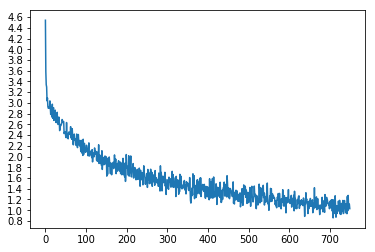

In [249]:
hidden_size = 100
bong_size = 0
with open('dictionary.pickle', 'rb') as handle:
        b = pkl.load(handle)
        bong_size = len(b)
print(bong_size)
decoder = DecoderRNN(hidden_size, output_lang.n_words, bong_size)

trainIters(decoder, 75000, print_every=5000)

In [254]:
evaluateRandomly(decoder)

> Variable containing:
    7
 9843
 3317
 9844
 3742
    0
    0
    0
[torch.LongTensor of size 8]

= Variable containing:
   14
   15
  629
  529
  630
    4
    1
[torch.LongTensor of size 7x1]

= he s feeling really low . EOS
< he s a professional . <EOS>

> Variable containing:
 194
   3
  23
 203
   0
   0
   0
   0
[torch.LongTensor of size 8]

= Variable containing:
 130
  78
 295
 535
   4
   1
[torch.LongTensor of size 6x1]

= you re the oldest . EOS
< you re the oldest . <EOS>

> Variable containing:
  13
   3
 244
 192
   0
   0
   0
   0
[torch.LongTensor of size 8]

= Variable containing:
 130
  78
 304
 429
   4
   1
[torch.LongTensor of size 6x1]

= you re very brave . EOS
< you re very brave . <EOS>

> Variable containing:
 8433
 8451
 8470
 8471
    4
 1029
 1996
    0
[torch.LongTensor of size 8]

= Variable containing:
   77
   78
  216
  539
 2297
  811
 2421
    4
    1
[torch.LongTensor of size 9x1]

= we re working to fix this bug . EOS
< we re in only in than y

In [226]:
print(pairs[0])

[Variable containing:
   24
 2415
 2406
   92
    0
    0
    0
    0
[torch.LongTensor of size 8]
, Variable containing:
  222
  125
  304
 1695
    4
    1
[torch.LongTensor of size 6x1]
]
